In [31]:
#Download glove

# import urllib.request
# import zipfile
# import os
# from tqdm import tqdm

# # Download the GloVe word vectors
# url = "http://nlp.stanford.edu/data/glove.6B.zip"
# output = "glove.6B.zip"
# def download_progress(block_num, block_size, total_size):
#     progress = block_num * block_size / total_size * 100
#     print(f"\rDownloading: {progress:.2f}%", end='')

# urllib.request.urlretrieve(url, output, reporthook=download_progress)

# # Unzip the file
# # Add a progress bar to the unzip process
# class ZipFileWithProgress(zipfile.ZipFile):
#     def extractall(self, path=None, members=None, pwd=None):
#         if members is None:
#             members = self.namelist()
#         total = len(members)
        
#         with tqdm(total=total, unit='file') as pbar:
#             for member in members:
#                 self.extract(member, path, pwd)
#                 pbar.update(1)

# # Use the custom ZipFileWithProgress class
# with ZipFileWithProgress(output, 'r') as zip_ref:
#     zip_ref.extractall("glove.6B")

# # List the extracted files
# print(os.listdir("glove.6B"))

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import re

def get_vocabulary(text : str,
                   expr: str=r"\b\w+\b",
                   case_sensitive : bool=False,
                   ) -> dict:
    if case_sensitive == False:
        text = text.lower()  
    vocabulary = set(re.findall(expr, text))
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for i, token in enumerate(vocabulary):
        if token not in vocab:
            vocab[token] = i+2 # We start from 2 because 0 and 1 are reserved for <UNK> and <PAD>
            inverse_vocab.append(token)
    return vocab, inverse_vocab

def tokenize_words(text : str,
             vocab : dict,
             expr : str= r"\b\w+\b",
             sentence_length : int = 10,
             case_sensitive : bool = False) -> list:
    if case_sensitive == False:
        text = text.lower()
    words = re.findall(expr, text)
    tokens = []
    for i, w in enumerate(words):
        if i == sentence_length:
            break
        if w in vocab:
            tokens.append(vocab[w])
        else:
            tokens.append(vocab["<UNK>"])


    if len(tokens) < sentence_length:
        n_pad = sentence_length - len(tokens)
        pad = [vocab["<PAD>"]] * n_pad
        tokens = pad + tokens
    return tokens

def detokenize_words(tokens : list,
                    invert_vocab : list) -> str:
    text = " ".join([invert_vocab[token] for token in tokens])
    return text

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text)
        x = torch.tensor(tokens)
        y = torch.tensor(label).reshape(1).clone().detach()
        return x, y
    
class MyTokenizer:
    def __init__(self, sentence_length, case_sensitive=False):
        self.sentence_length = sentence_length
        self.case_sensitive = case_sensitive

    def fit(self, phrases : list, expr : str=r"\b\w+\b"):
        self.vocab, self.inverse_vocab = get_vocabulary(" ".join(phrases),
                                                        expr=expr,
                                                        case_sensitive=self.case_sensitive)
        self.vocab_size = len(self.vocab)
        
    def __call__(self, x):
        return tokenize_words(x,
                              self.vocab,
                              sentence_length=self.sentence_length,
                              case_sensitive=self.case_sensitive)

def load_glove_vectors(glove_file):
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            glove_vectors[word] = vector
    return glove_vectors

glove_file = "glove.6B/glove.6B.300d.txt"  # Change this to the appropriate file if needed
glove_vectors = load_glove_vectors(glove_file)


def get_vocabulary_from_glove(glove_vectors):
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for word, vector in glove_vectors.items():
        vocab[word] = len(inverse_vocab)
        inverse_vocab.append(word)
    return vocab, inverse_vocab

vocab, inverse_vocab = get_vocabulary_from_glove(glove_vectors)

In [33]:
embedding_dim = 300  # This should match the dimension of the GloVe vectors
vocab_size = len(glove_vectors) + 2
embedding = nn.Embedding(vocab_size, embedding_dim)

for idx, word in enumerate(inverse_vocab[2:]):
    i = idx + 2
    embedding.weight[i].data = glove_vectors[word]

print("Embedding layer created with shape:", embedding.weight.shape)

Embedding layer created with shape: torch.Size([400002, 300])


In [34]:
import pandas as pd
import re

# Example DataFrame
df = pd.read_csv('Data.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/refs/heads/main/Aulas/datasets/IMDB%20Dataset.csv').sample(1000)
df = df[df.index < 360]

def clean_text(text, begin, end):
    start_idx = text.find(begin)
    end_idx = text.find(end)
    fool_idx = text.find("April Fool")
    if fool_idx != -1:
        text = text[:fool_idx]
    if start_idx != -1 and end_idx != -1:
        return text [:start_idx] + text[end_idx+len(end):]
    return text

def remove_enters(text):
    return text.replace('\n', ' ')

begin = "Unlock"
end = "Localization:"
begin_list = ["Unlock", "Bond 1", "Bond 2", "Bond 3", "Bond 4", "Bond 5", "Extra"]
for begin in begin_list:
    df['Description'] = df['Description'].apply(lambda x: clean_text(x, begin, end))
    
df['Description'] = df['Description'].apply(remove_enters)

def class_edit(text):
    return int(text[0])

df['Rarity'] = df['Rarity'].apply(class_edit)

df.head(5)

,Servant Name,ID,Rarity,Link,Description
0,Mashu Kyrielight,1,4,Mashu_Kyrielight,"This is Chaldea staff, Mash Kyrielight. After..."
1,Artoria Pendragon,2,5,Artoria_Pendragon,"Legendary King of Britain, and the King of Kn..."
2,Artoria Pendragon (Alter),3,4,Artoria_Pendragon_(Alter),"Corrupted by the curse of the Holy Grail, thi..."
3,Artoria Pendragon (Lily),4,4,Artoria_Pendragon_(Lily),"Pulling Caliburn the Sword of Selection out, ..."
4,Nero Claudius,5,4,Nero_Claudius,"A mighty emperor, and self-proclaimed ""beauty..."


In [35]:
len(df)

360

In [ ]:
class MyOtherClassifier( nn.Module ):
    def __init__(self, vocab_size, embedding_layer, embedding_dim, hidden_dim, output_dim, n_special_tokens=2, n_layers=10):
        super(MyOtherClassifier, self).__init__()
        self.n_special_tokens = n_special_tokens
        self.embedding = embedding_layer
        self.hidden = hidden_dim
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc_multi = self.multi_layered(n_layers)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def _pool(self, x):
        x = torch.mean(x, dim=1)
        return x

    def multi_layered(self, n):
        layers = nn.Sequential()
        for i in range(n):
            layers.add_module(f'layer{i}', nn.Linear(self.hidden, self.hidden))
        return layers

    def forward(self, x):
        x = self.embedding(x)
        y = self._pool(x)
        z = self.fc(y)
        z = self.relu(z)
        z = self.fc_multi(z)
        z_ = self.relu(z)
        z = self.fc2(z_)
        return z, y, z_
    

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Rarity'], test_size=0.2, random_state=33)
classes = list(set(y_train))

print(classes)

[1, 2, 3, 4, 5]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Tiago\AppData\Local\Temp\ipykernel_12984\4292786007.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(label).reshape(1).clone().detach()
100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


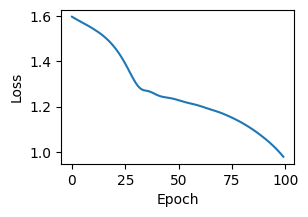

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm 

y_train_bin = torch.tensor([[classes.index(y) for y in y_train]]).T
y_test_bin = torch.tensor([[classes.index(z) for z in y_test]]).T

# Train the tokenizer
tokenizer = MyTokenizer(sentence_length=100)
tokenizer.fit(X_train)

dataset = TextDataset(list(X_train), y_train_bin, tokenizer)
dataloader = DataLoader(dataset, batch_size=312, shuffle=True)

model = MyOtherClassifier(vocab_size=tokenizer.vocab_size,
                          embedding_layer=embedding,
                          embedding_dim=300, 
                          hidden_dim=312,
                          output_dim=5,
                          n_special_tokens=2,
                          n_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # lr is the learning rate - this is our alpha
loss_fn = nn.CrossEntropyLoss() # Binary Cross Entropy from Logits
# And now, a loop that is equal for everyone:

losses = []
for epoch in tqdm(range(100)):
    epoch_loss = 0
    for batch in dataloader:
        X_train_vect, y_train_vect = batch
        y_train_vect = y_train_vect.reshape( (-1,) )
        optimizer.zero_grad()
        output, y_pool, output_ = model(X_train_vect)
        loss = loss_fn(output, y_train_vect)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))


plt.figure(figsize=(3,2))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

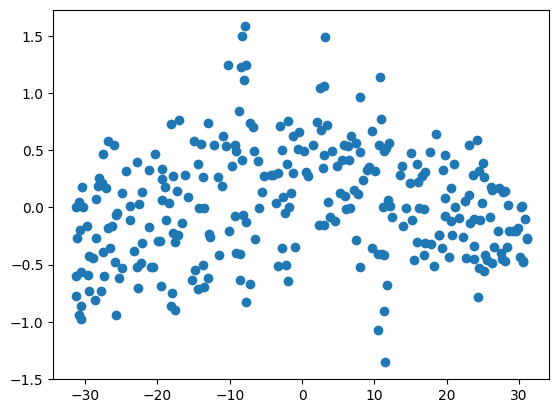

In [39]:
# Pre-trained Embeddings
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2)
X_proj = tsne.fit_transform(output.detach().numpy())

plt.scatter(X_proj[:, 0], X_proj[:, 1])


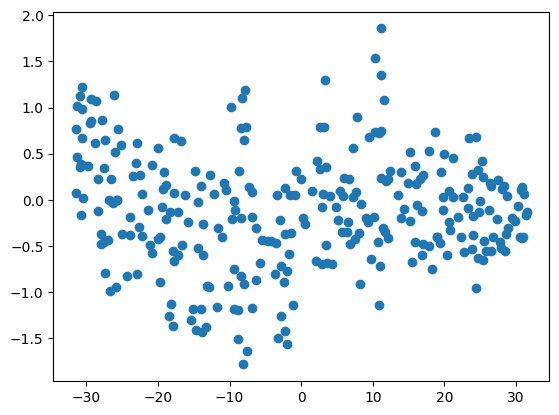

In [40]:
# Tunned Embeddings
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2)
X_proj = tsne.fit_transform(output_.detach().numpy())

plt.scatter(X_proj[:, 0], X_proj[:, 1])

In [ ]:
# Non-obvious
query = 'smoke'
token_query = tokenizer(query)
tensor_query = torch.tensor(token_query).reshape((1,-1))
model_query, query_pool, model_query_ = model(tensor_query)
similarity = y_pool @ query_pool.T
reasonable_similarities = {}

result = pd.merge(df, X_train, on='Description')
filtered_df = result[result['Servant Name'].str.contains('William Tell', case=False)]
ids = filtered_df.index.tolist()

will_sim = (similarity[ids[0]][0])
print("William Tell, the only character with the word 'smoke' on his Description, has a similarity of", "%.2f" % float(will_sim), "with that word")

William Tell, the only character with the word 'smoke' on his Description, has a similarity of 0.78 with that word


In [ ]:
# Less than 10 results
query = 'Santa Claus wears red on christmas eve, delivers presents, and brings joy to all children that are good. Coal to the naughty ones.'
token_query = tokenizer(query)
tensor_query = torch.tensor(token_query).reshape((1,-1))
model_query, query_pool, model_query_ = model(tensor_query)
similarity = y_pool @ query_pool.T
similarities_less = {}

for i in range(len(similarity)):
    if similarity[i][0] > 5:
        similarities_less[i] = similarity[i][0]

print("The amount of characters with a similarity greater than 5 is",len(similarities_less))


The amount of characters with a similarity greater than 5 is 4


In [48]:
# 10 results
query_10 = 'A teacher is someone that helps you learn to improve yourself, to be a better person'
token_query_10 = tokenizer(query_10)
tensor_query_10 = torch.tensor(token_query_10).reshape((1,-1))
model_query, query_pool_10, model_query_ = model(tensor_query_10)
similarity_10 = y_pool @ query_pool_10.T
similarities_10 = {}

for i in range(len(similarity_10)):
    if similarity_10[i][0] > 3:
        similarities_10[i] = similarity_10[i][0]

print("The amount of characters with a similarity greater than 3 is",len(similarities_10))

The amount of characters with a similarity greater than 3 is 10
